In [1]:
import sys, os

sys.path.append(os.path.join(".."))

In [2]:
import pandas as pd 

games = pd.read_csv("../data/gsw_games.csv", parse_dates = ["GAME_DATE"])
box = pd.read_csv("../data/gsw_boxscores.csv")

games.tail(), box.head()

(     SEASON_ID     TEAM_ID TEAM_ABBREVIATION              TEAM_NAME   GAME_ID  \
 104      42024  1610612744               GSW  Golden State Warriors  42400231   
 105      42024  1610612744               GSW  Golden State Warriors  42400232   
 106      42024  1610612744               GSW  Golden State Warriors  42400233   
 107      42024  1610612744               GSW  Golden State Warriors  42400234   
 108      42024  1610612744               GSW  Golden State Warriors  42400235   
 
      GAME_DATE      MATCHUP WL  MIN  PTS  ...  OREB  DREB   REB  AST  STL  \
 104 2025-05-06    GSW @ MIN  W  241   99  ...  18.0  33.0  51.0   26   10   
 105 2025-05-08    GSW @ MIN  L  238   93  ...  10.0  32.0  42.0   23    8   
 106 2025-05-10  GSW vs. MIN  L  240   97  ...  12.0  24.0  36.0   21    6   
 107 2025-05-12  GSW vs. MIN  L  242  110  ...  14.0  24.0  38.0   18   10   
 108 2025-05-14    GSW @ MIN  L  242  110  ...  18.0  22.0  40.0   21   14   
 
      BLK  TOV  PF  PLUS_MINUS  SEAS

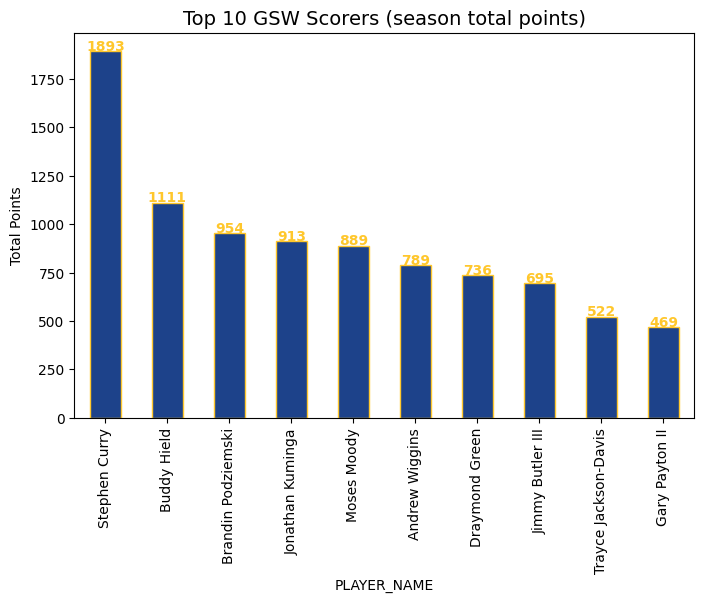

In [3]:
import matplotlib.pyplot as plt 

scorers = (
    box.groupby("PLAYER_NAME")["PTS"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

#Plotting with GSW Colors
plt.figure(figsize=(8, 5))
scorers.plot(kind='bar', color="#1D428A", edgecolor="#FFC72C")
plt.title("Top 10 GSW Scorers (season total points)", fontsize=14)
plt.ylabel("Total Points")

for i, v in enumerate(scorers):
    plt.text(i, v + 5, str(int(v)), ha="center", fontweight='bold', color="#FFC72C")
plt.show()


In [4]:
from scripts.common_center_utils import pipeline, summarize_games

# Use the exact same logic as the script
games, box_gsw, starters_c, allowed_trad = pipeline(games, box)

summary = summarize_games(games)

# Pretty display with whole numbers
summary_display = summary.copy()
summary_display[["avg_pts_scored","avg_pts_allowed","net_rating","win_rate"]] = (
    summary_display[["avg_pts_scored","avg_pts_allowed","net_rating","win_rate"]]
    .round(0).astype("Int64")
)
summary_display[["label","games_played","wins","win_rate","avg_pts_scored","avg_pts_allowed","net_rating"]]

,label,games_played,wins,win_rate,avg_pts_scored,avg_pts_allowed,net_rating
0,Without Traditional Center,32,23,72,113,105,8
1,With Traditional Center,62,30,48,112,112,0


In [5]:
# Sanity check: Is Kevon Looney being detected as a traditional center?
print("Allowed traditional centers:", sorted(allowed_trad))

looney_starts = box_gsw[
    (box_gsw["PLAYER_NAME"].str.upper().str.strip() == "KEVON LOONEY") &
    (box_gsw["START_POSITION"].astype(str).str.upper().str.contains("C"))
][["GID_NORM", "PLAYER_NAME", "START_POSITION"]].drop_duplicates()

print("\nLooney starts:")
display(looney_starts.head(15))

looney_gid = set(looney_starts["GID_NORM"])
print("\nLooney HAS_CENTER flags:")
display(games.loc[games["GID_NORM"].isin(looney_gid), ["GAME_DATE", "MATCHUP", "HAS_CENTER"]].head(15))

Allowed traditional centers: ['KEVON LOONEY', 'QUINTEN POST', 'TRAYCE JACKSON-DAVIS']

Looney starts:


,GID_NORM,PLAYER_NAME,START_POSITION
979,22400058,Kevon Looney,C
1019,22400332,Kevon Looney,C
1044,22400338,Kevon Looney,C
1123,22401228,Kevon Looney,C
1135,22400366,Kevon Looney,C
1576,22400619,Kevon Looney,C



Looney HAS_CENTER flags:


,GAME_DATE,MATCHUP,HAS_CENTER
33,2024-12-03,GSW @ DEN,True
34,2024-12-05,GSW vs. HOU,True
35,2024-12-06,GSW vs. MIN,True
38,2024-12-15,GSW vs. DAL,True
39,2024-12-19,GSW @ MEM,True
56,2025-01-22,GSW @ SAC,True


In [10]:
sorted(allowed_trad)

with_ids = set(games.loc[games["HAS_CENTER"], "GID_NORM"])
box_gsw.loc[(box_gsw["GID_NORM"].isin(with_ids)) & (box_gsw["START_POSITION"] == "C"),
            ["GID_NORM","PLAYER_NAME","START_POSITION"]].drop_duplicates().head(15)

,GID_NORM,PLAYER_NAME,START_POSITION
478,22400072,Trayce Jackson-Davis,C
507,22400084,Trayce Jackson-Davis,C
549,22400101,Trayce Jackson-Davis,C
575,22400116,Trayce Jackson-Davis,C
601,22400126,Trayce Jackson-Davis,C
615,22400144,Trayce Jackson-Davis,C
641,22400155,Trayce Jackson-Davis,C
668,22400172,Trayce Jackson-Davis,C
694,22400188,Trayce Jackson-Davis,C
721,22400207,Trayce Jackson-Davis,C


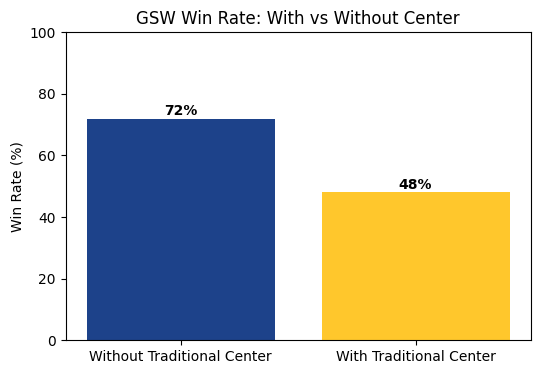

In [7]:
labels = summary["label"].tolist()
win_rates = summary["win_rate"].round(0).astype(int).tolist()

plt.figure(figsize=(6,4))
plt.bar(labels, win_rates, color=["#1D428A", "#FFC72C"])
plt.title("GSW Win Rate: With vs Without Center")
plt.ylabel("Win Rate (%)")
plt.ylim(0, 100)

for i, v in enumerate(win_rates):
    plt.text(i, v + 1, f"{v}%", ha="center", fontweight="bold")
plt.show()

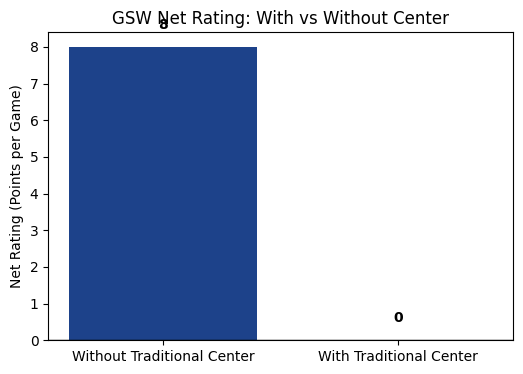

In [8]:
net_ratings = summary["net_rating"].round(0).astype(int).tolist()

plt.figure(figsize=(6,4))
plt.bar(labels, net_ratings, color=["#1D428A", "#FFC72C"])
plt.title("GSW Net Rating: With vs Without Center")
plt.ylabel("Net Rating (Points per Game)")

for i, v in enumerate(net_ratings):
    plt.text(i, v + (0.5 if v >= 0 else -1.5), f"{v}", ha="center", fontweight="bold")
plt.axhline(0, color="black", linewidth=1)
plt.show()

In [9]:
# Show a few games we counted as "with traditional center"
with_center_ids = set(games.loc[games["HAS_CENTER"], "GID_NORM"])
box_gsw.loc[(box_gsw["GID_NORM"].isin(with_center_ids)) & (box_gsw["START_POSITION"] == "C"),
            ["GID_NORM","PLAYER_NAME","START_POSITION"]].drop_duplicates().head(15)

,GID_NORM,PLAYER_NAME,START_POSITION
478,22400072,Trayce Jackson-Davis,C
507,22400084,Trayce Jackson-Davis,C
549,22400101,Trayce Jackson-Davis,C
575,22400116,Trayce Jackson-Davis,C
601,22400126,Trayce Jackson-Davis,C
615,22400144,Trayce Jackson-Davis,C
641,22400155,Trayce Jackson-Davis,C
668,22400172,Trayce Jackson-Davis,C
694,22400188,Trayce Jackson-Davis,C
721,22400207,Trayce Jackson-Davis,C


In [11]:
import pandas as pd
from pathlib import Path

DATA_DIR = Path("../data")  # adjust if needed
OUT_DIR = DATA_DIR / "cleaned"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Load
bench = pd.read_csv(DATA_DIR / "bench_15to24.csv")

# Normalize team abbreviation
if "TEAM_ABBREVIATION" in bench.columns:
    bench["TEAM_ABBREVIATION"] = bench["TEAM_ABBREVIATION"].astype(str).str.strip().str.upper()

# Choose points column — adjust if different
points_col = "PTS"

# Sort by team, then by points descending
bench_sorted = bench.sort_values(
    by=["TEAM_ABBREVIATION", points_col],
    ascending=[True, False],  # teams A→Z, then highest points first
    kind="mergesort"
)

# Save cleaned
bench_sorted.to_csv(OUT_DIR / "bench_15to24_sorted.csv", index=False)
print(f"Saved: {OUT_DIR / 'bench_15to24_sorted.csv'}")

Saved: ..\data\cleaned\bench_15to24_sorted.csv


In [12]:
for abbr, sub in bench_sorted.groupby("TEAM_ABBREVIATION"):
    sub.to_csv(OUT_DIR / f"{abbr}_bench_15to24.csv", index=False)